# Controle da carteira de ações (Swing Trade)

### Referências para o programa.

[Link](https://gspread.readthedocs.io/en/latest/api.html#module-gspread.utils) de uma documentação
das planilhas do google.

[Link](https://www.twilio.com/blog/2017/02/an-easy-way-to-read-and-write-to-a-google-spreadsheet-in-python.html) descrevendo como fazer para pegar as autenticações do google spreadsheet.

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [288]:
sns.set(style="white")

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelpad'] = 15

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 3

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 3

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.markerscale'] = 1

plt.rcParams['lines.markersize'] = 9
plt.rcParams['lines.linewidth'] = 2

### Credênciais para a API do Google

In [264]:
scope = ['https://www.googleapis.com/auth/spreadsheets',
        'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('cred.json', scope)
client = gspread.authorize(creds)

### Lê o dataset organizado

In [265]:
df_ativos = pd.read_csv('Dataset_ações_2019.csv')
df_ativos['Data'] = pd.to_datetime(df_ativos['Data'], format="%Y/%m/%d")
df_ativos.head()

,Data,Código,Mercado,Especificação,Tipo de Execução,Quantidade de C/V,Valor Total,Preço de C/V,Preço Atual,L/P,Quantidade Atual
0,2019-07-11,CVCB3,Fracionário,CVC BRASIL ON NM,C,10.0,530.00,53.00,53.00,0.0,10.0
1,2019-07-11,PETR4,Fracionário,PETROBRAS PN N2,C,17.0,478.89,28.17,28.17,0.0,17.0
2,2019-07-11,RAIL3,Fracionário,RUMO S.A. ON NM,C,20.0,443.40,22.17,22.17,0.0,20.0
3,2019-07-11,VALE3,Fracionário,VALE ON NM,C,10.0,520.00,52.00,52.00,0.0,10.0
4,2019-07-19,CVCB3,Fracionário,CVC BRASIL ON NM,V,-10.0,487.00,48.70,53.00,-43.0,0.0


# Funções

In [266]:
def carteira_de_acoes_atual(df):
    
    carteira = pd.DataFrame(columns=df.columns)

    cods = df['Código'].unique()
    
    for cod in cods:

        last_idx = df[df[['Código']] == cod].last_valid_index() 

        carteira = carteira.append(df.iloc[last_idx], ignore_index=True)

    carteira = carteira[carteira['Quantidade Atual'] != 0.0]
    
    carteira.sort_values(by='Data', ascending=True, inplace=True)
    
    drop_columns = ['Especificação', 'Tipo de Execução', 'Quantidade de C/V', 'Mercado', 'Preço de C/V']
    
    carteira.drop(drop_columns, inplace=True, axis=1)
    
    carteira.rename(columns={'Preço Atual': '<Preço>'}, inplace=True)
    
    carteira.reset_index(drop=True, inplace=True)
    
    carteira['<Valor Total>'] = carteira['Quantidade Atual'] * carteira['<Preço>']
    
    carteira['Preço Atual'] = get_market_values(carteira['Código'])

    carteira['Valor Total Atual'] = carteira['Quantidade Atual'] * carteira['Preço Atual']
    
    carteira['L/P'] = carteira['Quantidade Atual'] * ( carteira['Preço Atual'] - carteira['<Preço>'] )

    carteira['L/P (%)'] = (carteira['L/P'] / (carteira['<Preço>'] * carteira['Quantidade Atual'])) * 100.0

    carteira['L/P'] = carteira['L/P'].round(2)

    carteira['L/P (%)'] = carteira['L/P (%)'].round(2) 
    
    carteira['<Preço>'] = carteira['<Preço>'].round(2)
    
    
    cols_ordenadas = ['Data', 'Código', 'Quantidade Atual', '<Preço>', '<Valor Total>',
                      'Preço Atual', 'Valor Total Atual', 'L/P', 'L/P (%)']

    return carteira[cols_ordenadas]

In [267]:
def get_market_values(names):
    
    market_values = client.open('Google_Finance').sheet1

    size = names.shape[0]
    
    cell_list = market_values.range('A1:A' + str(size))

    for i, cell in enumerate(cell_list):
        cell.value = names[i]
        market_values.update_acell('B' + str(i + 1), '=GOOGLEFINANCE(A' + str(i + 1) + ';"price")')

    market_values.update_cells(cell_list);

    market_values = market_values.col_values(2)[0:size]
    
    market_values = [float(market_values[i].replace(',', '.')) for i in range(size)]
      
    return np.asarray(market_values)

In [268]:
def update_carteira_online(carteira):

    carteira['Data'] = carteira['Data'].dt.strftime('%d-%m-%Y')

    carteira['Preço Atual'] = ['=GOOGLEFINANCE(B' + str(i) + '; "price")' for i in range(2, carteira.shape[0]+2)]

    carteira['<Valor Total>'] = ['=D' + str(i) + ' * C' + str(i) for i in range(2, carteira.shape[0]+2)]

    carteira['Valor Total Atual'] = ['=F' + str(i) + ' * C' + str(i) for i in range(2, carteira.shape[0]+2)]

    carteira['L/P'] = ['=G' + str(i) + ' - E' + str(i) for i in range(2, carteira.shape[0]+2)]

    carteira['L/P (%)'] = ['=(H' + str(i) + ' / E' + str(i) + ')' for i in range(2, carteira.shape[0]+2)]

    google_sheet = client.open('Carteira de Ações').sheet1
    google_sheet.clear()

    google_sheet.insert_row(carteira.columns.to_list(), index=1)

    for row in range(carteira.shape[0]):
        google_sheet.insert_row(carteira.iloc[row].to_list(), index=row+2, value_input_option='USER_ENTERED')

In [269]:
def save_last(df_all):
    
    df_carteira = pd.DataFrame(columns = df_all.columns)
    df_carteira['Data Negócio'] = carteira['Data']
    df_carteira['C/V'] = 'C'
    df_carteira['Quantidade'] = carteira['Quantidade Atual']
    df_carteira['Código'] = carteira['Código'].apply(lambda x: str(x) + 'F')
    df_carteira['Preço (R$)'] = carteira['<Preço>']
    df_carteira['Valor Total (R$)'] = carteira['<Valor Total>']
    df_carteira['Mercado'] = 'Merc. Fracionário'

    for cod in df_carteira['Código']:

        df_carteira.loc[df_carteira['Código'] == cod, 'Especificação do Ativo'] = df_all.loc[df_all['Código'] == cod, 'Especificação do Ativo'].iloc[-1]

    return df_carteira

### Carteira Atual

In [270]:
sheet = client.open("Carteira de Ações").sheet1

In [271]:
carteira = carteira_de_acoes_atual(df_ativos)
carteira

,Data,Código,Quantidade Atual,<Preço>,<Valor Total>,Preço Atual,Valor Total Atual,L/P,L/P (%)
0,2019-09-05,PETR4,39.0,26.38,1028.68,22.83,890.37,-138.31,-13.45
1,2019-09-05,VALE3,25.0,49.80,1244.95,44.61,1115.25,-129.70,-10.42
2,2019-09-05,MGLU3,33.0,34.86,1150.27,45.33,1495.89,345.62,30.05
3,2019-09-05,CYRE3,21.0,24.16,507.36,27.75,582.75,75.39,14.86
4,2019-09-12,VVAR3,100.0,7.76,775.80,11.56,1156.00,380.20,49.01
5,2019-10-01,EZTC3,15.0,36.42,546.30,44.10,661.50,115.20,21.09
6,2019-11-04,JBSS3,21.0,28.49,598.39,21.01,441.21,-157.18,-26.27
7,2019-11-04,LCAM3,29.0,17.75,514.75,19.15,555.35,40.60,7.89
8,2019-12-03,RAIL3,21.0,25.22,529.62,19.30,405.30,-124.32,-23.47
9,2019-12-03,KLBN11,29.0,18.15,526.35,20.98,608.42,82.07,15.59


In [272]:
print('Lucro ao zerar a carteira: {0}'.format(carteira['L/P'].sum()))

Lucro ao zerar a carteira: 489.56999999999994


### Atualiza a carteira online

In [ ]:
#update_carteira_online(carteira.copy())

### Salva a última carteira de ativos do ano

In [ ]:
#df_carteira = save_last(df_all)
#df_carteira.to_csv('Ultima_carteira_2019.csv', index=False)

# Visualizações

In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Carteira Atual

In [273]:
carteira

,Data,Código,Quantidade Atual,<Preço>,<Valor Total>,Preço Atual,Valor Total Atual,L/P,L/P (%)
0,2019-09-05,PETR4,39.0,26.38,1028.68,22.83,890.37,-138.31,-13.45
1,2019-09-05,VALE3,25.0,49.80,1244.95,44.61,1115.25,-129.70,-10.42
2,2019-09-05,MGLU3,33.0,34.86,1150.27,45.33,1495.89,345.62,30.05
3,2019-09-05,CYRE3,21.0,24.16,507.36,27.75,582.75,75.39,14.86
4,2019-09-12,VVAR3,100.0,7.76,775.80,11.56,1156.00,380.20,49.01
5,2019-10-01,EZTC3,15.0,36.42,546.30,44.10,661.50,115.20,21.09
6,2019-11-04,JBSS3,21.0,28.49,598.39,21.01,441.21,-157.18,-26.27
7,2019-11-04,LCAM3,29.0,17.75,514.75,19.15,555.35,40.60,7.89
8,2019-12-03,RAIL3,21.0,25.22,529.62,19.30,405.30,-124.32,-23.47
9,2019-12-03,KLBN11,29.0,18.15,526.35,20.98,608.42,82.07,15.59


In [306]:
def f(col_name):
    
    plt.figure(figsize=[15, 9])
    
    df = carteira
    
    if col_name == 'L/P':
        
        tot = pd.DataFrame(data={'Código': ['Total'], col_name: [carteira[col_name].sum().round(2)]})

        df = carteira.append(tot, ignore_index=True)

    
        
    palette_c = ['r' if c < 0.0 else 'b' for c in df[col_name]]

    g = sns.barplot(data = df, x = 'Código', y = col_name, palette=palette_c)

    for index, row in df[[col_name]].reset_index().values:
        g.text(index, row, np.round(row, 2), color='black', ha="center", va='bottom',
               fontsize='large', fontweight='bold')


    plt.hlines(y=0, xmax=df.shape[0], xmin=-1)
    plt.title('Carteira Atual')
    plt.ylabel(col_name)
    plt.xlabel('')
    plt.show()

interactive(f, col_name=carteira.columns[2:].to_list())

interactive(children=(Dropdown(description='col_name', options=('Quantidade Atual', '<Preço>', '<Valor Total>'…

## Lucro por mês

In [177]:
months = lucro_df.reset_index()['Mês'].unique()

In [162]:
lucro_df = df_ativos.loc[(df_ativos['L/P'] != 0.0), ['Data', 'Código', 'L/P']]
lucro_df['Mês'] = lucro_df['Data'].dt.strftime('%b')
lucro_df = lucro_df.groupby(['Mês', 'Código'], sort=False).sum()

In [286]:
def f(month):
    
    df = lucro_df.loc[month].reset_index()
    
    tot = pd.DataFrame(data={'Código': ['Total'], 'L/P': [df['L/P'].sum().round(2)]})
    
    df = df.append(tot, ignore_index=True)
    
    palette_c = ['r' if c < 0.0 else 'b' for c in df['L/P']]
    
    plt.figure(figsize=[15, 9])

    g = sns.barplot(data = df, x = 'Código', y = 'L/P', palette=palette_c)

    for index, row in df[['L/P']].reset_index().values:
        g.text(index, row, np.round(row, 2), color='black', ha="center", va='bottom',
           fontsize='large', fontweight='bold')
        
    plt.hlines(y=0, xmax=df.shape[0], xmin=-1)
    plt.ylabel('Lucro  (R$)')
    plt.xlabel('')
    
    plt.show()

interactive(f, month=months)

interactive(children=(Dropdown(description='month', options=('Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), value=…

## Lucro no ano

In [253]:
lucro_mes = df_ativos.loc[(df_ativos['L/P'] != 0.0), ['Data', 'L/P']]
lucro_mes['Mês'] = lucro_mes['Data'].dt.strftime('%b')
lucro_mes = lucro_mes.groupby(['Mês'], sort=False).sum().reset_index()

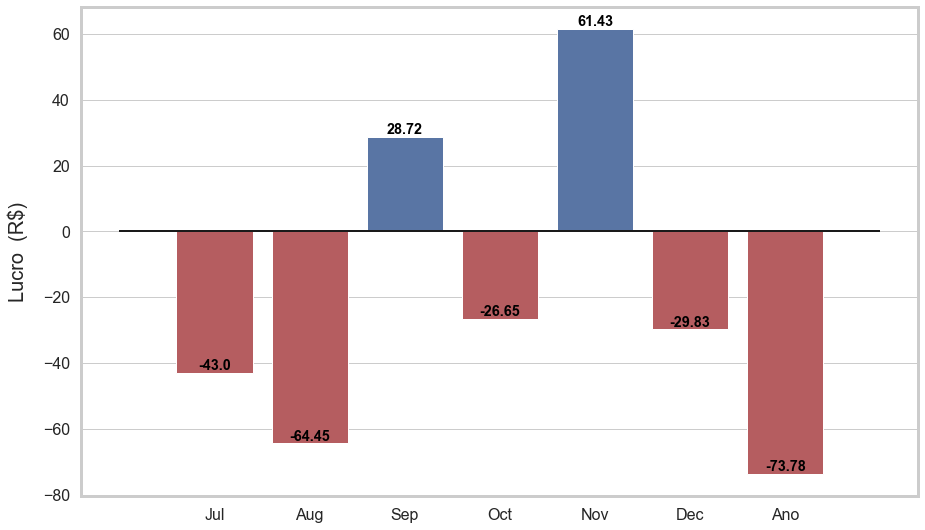

In [287]:
plt.figure(figsize=[15, 9])

tot = pd.DataFrame(data={'Mês': ['Ano'], 'L/P': [lucro_mes['L/P'].sum().round(2)]})
    
df = lucro_mes.append(tot, ignore_index=True)

palette_c = ['r' if c < 0.0 else 'b' for c in df['L/P']]

g = sns.barplot(data = df, x = 'Mês', y = 'L/P', palette=palette_c)

for index, row in df[['L/P']].reset_index().values:
    g.text(index, row, np.round(row, 2), color='black', ha="center", va='bottom',
           fontsize='large', fontweight='bold')

plt.hlines(y=0, xmax=df.shape[0], xmin=-1)
plt.ylabel('Lucro  (R$)')
plt.xlabel('')
plt.show()